In [ ]:
# !open .

In [ ]:
# firm_name = '서희건설'
firm_name = '키움증권'
# firm_name = '한국자산신탁'
# firm_name = '유진증권'
# firm_name = '메리츠증권'
# firm_name = '메리츠화재'
# firm_name = '삼성전자'
# firm_name = '코미코'
# firm_name = '현대건설'
# firm_name = 'GS건설'
# firm_name = '동원개발' 
# firm_name = 'HDC현대산업개발'
# firm_name = '삼성증권'
# firm_name = '이베스트투자증권'
# firm_name = '미래에셋대우'
# firm_name = 'DL이앤씨'

In [ ]:
import pandas as pd
import requests
import bs4

def request_price_list(company_code, timeframe, count):
    request_code = company_code
    if request_code.startswith('A'):
        request_code = request_code.replace('A','')
    url = 'https://fchart.stock.naver.com/sise.nhn?requestType=0'
    price_url = url + '&symbol=' + request_code + '&timeframe=' + timeframe + '&count=' + str(count)
    price_data = requests.get(price_url)
    price_data_bs = bs4.BeautifulSoup(price_data.text, 'lxml')
    item_list = price_data_bs.find_all('item')
    
    date_list = []
    price_list = []
    for item in item_list:
        temp_data = item['data']
        datas = temp_data.split('|')
        date_list.append(datas[0])
        price_list.append(datas[4])

    price_list = pd.to_numeric(price_list)
    price_df = pd.DataFrame({company_code:price_list}, index=date_list)
    price_df.index = pd.to_datetime(price_df.index)
    
    return price_df

def get_company_list(kospi = True):
    if kospi == True: 
        file_loc = 'data/kospi.xlsx'
    else:
        file_loc = 'data/kosdaq.xlsx'

    company = pd.read_excel(file_loc)
    company.code = company.code.map('{:06d}'.format)
    company = company.set_index(company.columns[0])
    return company

def get_all_company_list():
    kospi = get_company_list(True)
    kosdaq = get_company_list(False)
    kospi['type'] = 'kospi'
    kosdaq['type'] = 'kosdaq'
    companies = pd.concat([kospi, kosdaq], sort=False)
    return companies

def get_company_code(name, company_df):
    return company_df[company_df['company'] == name].index[0]


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# pd.set_option('display.max_colwidth', -1)
rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False


def show_price_chart(company_name, company_code, price_df):
    plt.figure(figsize=(20, 12))
    plt.plot(price_df.index, price_df[company_code], color='darkblue',linewidth=1.0)
    plt.plot(price_df.index, price_df['price_low'], color='blue',linewidth=3.0)
    plt.plot(price_df.index, price_df['price_middle'], color='green',linewidth=3.0)
    plt.plot(price_df.index, price_df['price_high'], color='red',linewidth=3.0)
    plt.title(company_name)
    plt.xlabel("duration")
    plt.ylabel("price")
    # plt.legend(loc='upper right')
    # plt.grid()
    plt.show() 


## get all company list

In [ ]:
companies = get_all_company_list()

## get fnguide snapshot

In [ ]:
firm_code = get_company_code(firm_name, companies)
print('firm name : ' + firm_name)
print('firm code : ' + firm_code)

if not firm_code.startswith('A'):
    firm_code = 'A' + firm_code

snapshot_url = 'http://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?pGB=1&cID=&MenuYn=Y&ReportGB=&NewMenuID=11&stkGb=701&gicode=' + firm_code
snapshot_page = requests.get(snapshot_url)
snapshot_tables = pd.read_html(snapshot_page.text)

## bond spread

In [ ]:
# https://www.kisrating.co.kr/ratingsStatistics/statics_spread.do
expected_ratio = 7.91

## get stock count

In [ ]:
import math

def get_total_stock_count(snapshot_tables):
    stock_count = 0

    info = snapshot_tables[0]
    info = info.set_index(info.columns[0])
    stock_count_info = info.loc['발행주식수(보통주/ 우선주)'][1]
    stock_counts = stock_count_info.split('/')
    for count in stock_counts:
#         print(count)
        stock_count = stock_count + int(count.replace(',',''))

    return stock_count

def get_self_stock_count(snapshot_tables):
    self_stock_count = 0
    info = snapshot_tables[4]
    info = info.set_index(info.columns[0])
    count = info.loc[['자기주식\xa0(자사주+자사주신탁)']]['보통주'][0]
#     print(count)
    if not math.isnan(count):
        self_stock_count = int(count)
    return self_stock_count

stock_count = get_total_stock_count(snapshot_tables) - get_self_stock_count(snapshot_tables)
print('stock count : ' + str(stock_count))

## get asset, roe

In [ ]:
import math

def get_standard_col_name(snapshot_tables):
    big_col_name = 'Annual'
    roe_index_name = 'ROE'
    asset_index_name = '지배주주지분'
    
    info = snapshot_tables[10]
    info = info.set_index(info.columns[0])

    stadard_col_name = ''
    roes = info.loc[roe_index_name][big_col_name]
    assets = info.loc[asset_index_name][big_col_name]
    for index in reversed(assets.index):
        if not math.isnan(assets[index]) and not math.isnan(roes[index]):
            stadard_col_name = index
            break
    return stadard_col_name

def get_roe(snapshot_tables, stadard_col_name):
    big_col_name = 'Annual'
    roe_index_name = 'ROE'
    
    info = snapshot_tables[10]
    info = info.set_index(info.columns[0])

    roe = info.loc[roe_index_name][big_col_name, stadard_col_name]
    return roe

def get_asset(snapshot_tables, stadard_col_name):
    big_col_name = 'Annual'
    asset_index_name = '지배주주지분'
    
    info = snapshot_tables[10]
    info = info.set_index(info.columns[0])

    asset = info.loc[asset_index_name][big_col_name, stadard_col_name]
    asset = asset * 100000000
    return asset

stadard_col_name = get_standard_col_name(snapshot_tables)
roe =  get_roe(snapshot_tables, stadard_col_name)
asset = get_asset(snapshot_tables, stadard_col_name)
print('standard date : ' + stadard_col_name)
print('asset : ' + str(asset))
print('roe : ' + str(roe))

## set roe manually

In [ ]:
# roe = 20

## get adequate price

In [ ]:
def get_adequate_price(asset, roe, expected_ratio, stock_count, persist_factor = 1):
    excess_profit = (roe - expected_ratio) * asset / 100
#     print(excess_profit)
    accumulate_profit = (persist_factor * excess_profit) / (1 + expected_ratio / 100 - persist_factor)
    adequate_stock_price = asset + accumulate_profit
#     print(adequate_stock_price)
    price = (asset + accumulate_profit) / stock_count
    price = int(round(price))
    return price

price_high = get_adequate_price(asset, roe, expected_ratio, stock_count, 1)
price_middel = get_adequate_price(asset, roe, expected_ratio, stock_count, 0.9)
price_low = get_adequate_price(asset, roe, expected_ratio, stock_count, 0.8)

print('buy : below ' + str(price_low))
print('sell 1/3 : ' + str(price_middel))
print('sell 1/3 : ' + str(price_high))

In [ ]:
price_df = request_price_list(firm_code, 'day', 1000)

In [ ]:
price_df['price_low'] = [price_low] * len(price_df)
price_df['price_middle'] = [price_middel] * len(price_df)
price_df['price_high'] = [price_high] * len(price_df)

In [ ]:
show_price_chart(firm_name, firm_code, price_df)

In [624]:
def get_ex_profits(asset, expected_ratio, roe, persist_factor, iteration = 10):
    next_asset = asset
    ex_profits = []
    ex_profit_ratio = roe - expected_ratio
    next_roe = roe
    for _ in range(iteration):
        ex_profit_ratio = ex_profit_ratio * persist_factor
        next_roe = expected_ratio + ex_profit_ratio
        profit = next_asset * (next_roe / 100)
        ex_profit = next_asset * ex_profit_ratio / 100
        ex_profits.append(ex_profit)
        next_asset = next_asset + profit
    return ex_profits
def get_npv_profit(ex_profits, expected_ratio):
    npv_value = 0
    for num, ex_profit in enumerate(ex_profits):
        ex_profit = ex_profit *  1 / (1 + expected_ratio / 100) ** (num + 1)
#         print(ex_profit)
        npv_value = npv_value + ex_profit

    return npv_value

def get_sum_of_profit(asset, expected_ratio, roe, persist_factor, iteration = 10):
    ex_profits = get_ex_profits(asset, expected_ratio, roe, persist_factor, iteration)
    sum_of_profit = get_npv_profit(ex_profits, expected_ratio)
    return sum_of_profit

def get_more_adequate_price(asset, roe, expected_ratio, stock_count, persist_factor = 1, iteration = 10):
    accumulate_profit = get_sum_of_profit(asset, expected_ratio, roe, persist_factor, iteration)
    adequate_stock_price = asset + accumulate_profit
    price = (asset + accumulate_profit) / stock_count
    price = int(round(price))
    return price

In [621]:
get_sum_of_profit(asset, expected_ratio, roe, 1, 10)

2768776976287.5293

In [625]:
price_high = get_more_adequate_price(asset, roe, expected_ratio, stock_count, 1)
price_middel = get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.9)
price_low = get_more_adequate_price(asset, roe, expected_ratio, stock_count, 0.8)

print('buy : below ' + str(price_low))
print('sell 1/3 : ' + str(price_middel))
print('sell 1/3 : ' + str(price_high))

buy : below 118862
sell 1/3 : 143112
sell 1/3 : 198420


In [626]:
price_df = request_price_list(firm_code, 'day', 1000)

In [627]:
price_df['price_low'] = [price_low] * len(price_df)
price_df['price_middle'] = [price_middel] * len(price_df)
price_df['price_high'] = [price_high] * len(price_df)

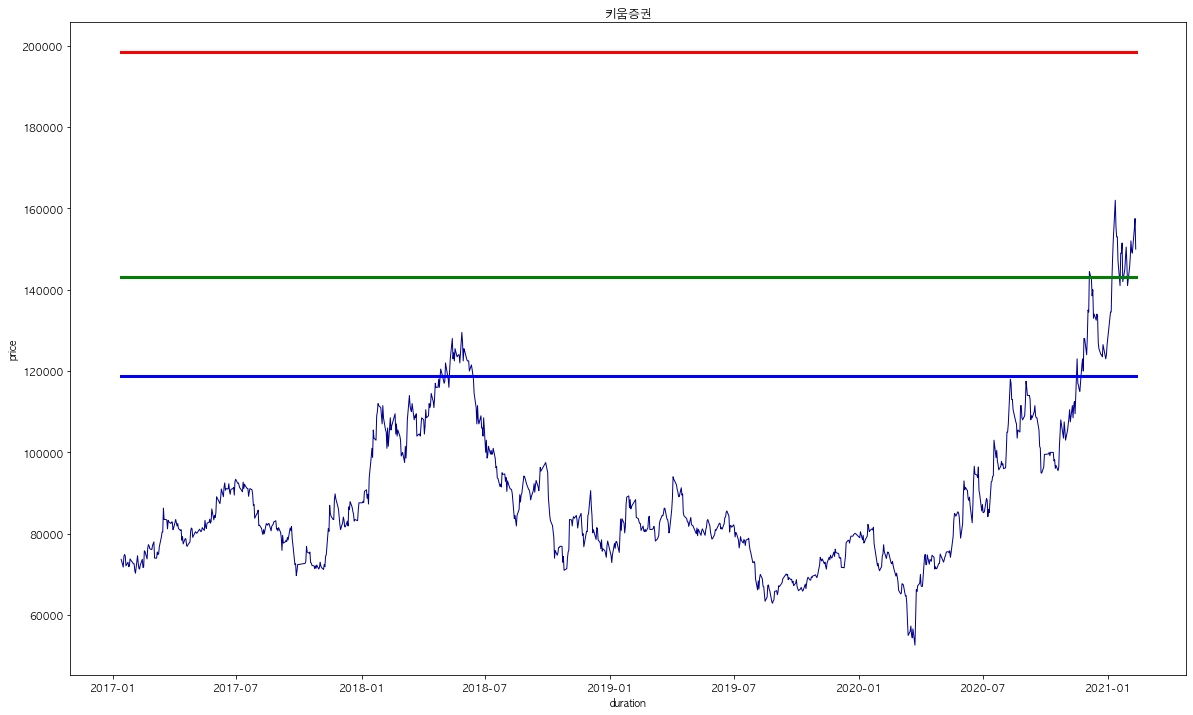

In [628]:
show_price_chart(firm_name, firm_code, price_df)